# Plot correlation function
This notebook is based on `correlation_function.py` that will produce the `.npz` file that is used here

In [2]:
from correlation_from_joint import *
import re

%config InlineBackend.figure_format ='retina'
import scipy.stats
from scipy.optimize import curve_fit
import scipy.optimize as optimize


SMALL_SIZE = 16
MEDIUM_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

%config InlineBackend.figure_format ='retina'

In [3]:
labels = {"l(t+dt)": "$\lambda(t+dt)$", 
            "l(t)": "$\lambda(t)$", 
            "q(t+dt)": "$q(t+dt)$", 
            "q(t)": "$q(t)$"}

### Correlation function class

In [4]:
class Correlation_function:
    '''
    Represents a Correlation function

    Constructed from a list of correlation instances

    Attributes:
        dt (np.array(N)):  List of time lags
        n (np.array(N)): List of number of joints
        corr_naive (np.array((8,8,N))): List of naive corrlation matrices
        corr_naive (np.array((8,8,N))): List of naive correlation matrices
        corr_mle (np.array((8,8,N))): List of mle correlation matrices
        corr_mle_err (np.array((8,8,N))): List of errors of mle 
    '''

    mapping = {z:i for i, z in enumerate(["x(t+dt)", "g(t+dt)", "l(t+dt)", "q(t+dt)", "x(t)", "g(t)", "l(t)", "q(t)"])}

    def __init__(self, correlations):
        dt = []
        n = []

        corr_naive = []
        corr_mle = []
        corr_mle_err = []
        for c in correlations:
            dt.append(c.dt)
            n.append(c.n)

            corr_naive.append(c.corr_naive)
            corr_mle.append(c.corr_mle)
            corr_mle_err.append(c.corr_mle_err)

        # save as numpy arrays
        self.dt = np.array(dt).astype(float)
        self.n = np.array(n)

        self.corr_naive = np.stack(corr_naive, axis=2)
        self.corr_mle = np.stack(corr_mle, axis=2)
        self.corr_mle_err = np.stack(corr_mle_err, axis=2)

    def filter_by_n(self, n=0):
        filter = np.where(self.n>=n, True, False)
        
        self.dt = self.dt[filter]
        self.n = self.n[filter]
        self.corr_naive = self.corr_naive[:, :, filter]

        self.corr_mle = self.corr_mle[:, :, filter]
        self.corr_mle_err = self.corr_mle_err[:, :, filter]

    def get_corr_naive(self, zi, zj):
        return self.corr_naive[self.mapping[zi], self.mapping[zj]]

    def get_corr_mle(self, zi, zj):
        return self.corr_mle[self.mapping[zi], self.mapping[zj]]

    def get_corr_mle_err(self, zi, zj):
        return self.corr_mle_err[self.mapping[zi], self.mapping[zj]]
    

### Plotting functions

In [5]:
def plot_correlation_tiles(corr_func, 
                            gamma_lambda=None, 
                            gamma_q=None, 
                            plot_file=None, 
                            xlim=[0, None], ylim=[-0.4, 1], 
                            min_joint_number=0,
                            title=None):
    
    fig, _ = plt.subplots(figsize=(8,8))

    if title!=None:
        fig.suptitle(title.replace('_', ' '), fontweight="bold")
    
    # ax0 = plt.subplot(321) # the figure has 3 row, 2 columns, and this plot is the first plot. 
    # ax1 = plt.subplot(322, sharex=ax0, sharey=ax0)

    # ax2 = plt.subplot(323, sharex=ax0, sharey=ax0)
    # ax3 = plt.subplot(324, sharex=ax0, sharey=ax0)
    # ax4 = plt.subplot(313) 

    ax0 = plt.subplot2grid((3, 2), (0, 0)) # the figure has 3 row, 2 columns, and this plot is the first plot. 
    ax1 = plt.subplot2grid((3, 2), (0, 1), sharex=ax0, sharey=ax0)
    ax2 = plt.subplot2grid((3, 2), (1, 0), sharex=ax0, sharey=ax0)
    ax3 = plt.subplot2grid((3, 2), (1, 1), sharex=ax0, sharey=ax0)
    ax4 = plt.subplot2grid((3, 2), (2, 0), colspan=2) 
    fig.tight_layout(h_pad=4)

    for ax in [ax0, ax1, ax2, ax3, ax4]:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        # set the x-spine
        ax.spines['left'].set_position('zero')

        # turn off the right spine/ticks
        ax.spines['right'].set_color('none')
        ax.yaxis.tick_left()


    for ax in [ax0, ax1, ax2, ax3]:
        # set the y-spine
        ax.spines['bottom'].set_position('zero')

        # turn off the top spine/ticks
        ax.spines['top'].set_color('none')
        ax.xaxis.tick_bottom()
        ax.tick_params(axis='x', pad=14)
        # remove first tick
        ax.xaxis.get_major_ticks()[0].set_visible(False)


    cf = copy.deepcopy(corr_func)
    cf.filter_by_n(min_joint_number)
    ######### Actual plots #########
    # ll
    ax0.errorbar(cf.dt, 
                cf.get_corr_mle("l(t+dt)", "l(t)"), 
                yerr=cf.get_corr_mle_err("l(t+dt)", "l(t)"),
                color="tab:blue")

    ax0.set_title(r"$\lambda(t+dt),\lambda(t)$", y=1, pad=-14)
    if gamma_lambda!=None:
        ax0.plot(cf.dt, np.exp(-gamma_lambda*cf.dt), color='grey', ls='--')

    # qq
    ax1.errorbar(cf.dt, 
                cf.get_corr_mle("q(t+dt)", "q(t)"), 
                yerr=cf.get_corr_mle_err("q(t+dt)", "q(t)"),
                color="tab:blue")

    ax1.set_title(r"$q(t+dt),q(t)$", y=1, pad=-14)
    if gamma_q!=None:
        ax1.plot(cf.dt, np.exp(-gamma_q*cf.dt), color='grey', ls='--')

    #ql
    ax2.errorbar(cf.dt, 
                cf.get_corr_mle("q(t+dt)", "l(t)"), 
                yerr=cf.get_corr_mle_err("q(t+dt)", "l(t)"),
                color="tab:orange")
    ax2.set_title(r"$q(t+dt),\lambda(t)$", y=1, pad=-14)

    #lq
    ax3.errorbar(cf.dt, 
                cf.get_corr_mle("l(t+dt)", "q(t)"), 
                yerr=cf.get_corr_mle_err("l(t+dt)", "q(t)"),
                color="tab:orange")
    ax3.set_title(r"$\lambda(t+dt),q(t)$", y=1, pad=-14)
    

    ax4.plot(cf.dt, cf.n, color="darkgrey")
    ax4.set_title("Number of joints", y=1.0, pad=-14)
    ax2.set_xlabel(r"time lag $dt$ (min)")
    ax3.set_xlabel(r"time lag $dt$ (min)")
    ax4.set_xlabel(r"time lag $dt$ (min)")

    if xlim[1]!=None:
        ns = [n for i,n in enumerate(cf.n) if cf.dt[i]<xlim[1] and cf.dt[i]>xlim[0] ]
        ax4.set_ylim([np.min(ns)*0.99, np.max(ns) *1.01 ])

    for ax in [ax0, ax1, ax2, ax3, ax4]:
        ax.set_xlim(xlim)
    for ax in [ax0, ax1, ax2, ax3]:
        ax.set_ylim(ylim)

    fig.tight_layout(h_pad=4)
    if plot_file != None:
        print("Saved in", plot_file)
        fig.savefig(plot_file, dpi=300, facecolor="white")
    else:
        plt.show()
    

In [6]:
def plot_xy_correlation(corr_func, x, y, 
                        gamma=None, 
                        mean_lambda=None, 
                        plot_file=None, 
                        title=None, 
                        xlim=[0, None], 
                        ylim=[None, None], 
                        min_joint_number=0):

    correlation_function = copy.deepcopy(corr_func)

    correlation_function.filter_by_n(min_joint_number)
    dts = correlation_function.dt
    rs = correlation_function.get_corr_mle(x,y)
    errs = correlation_function.get_corr_mle_err(x,y)

    corr_naive = correlation_function.get_corr_naive(x,y)

    # =========== plot =========== #
    # prepare axes depending on whether exponential is plotted
    if gamma!=None:
        fig, _ = plt.subplots(figsize=(8,8))
        ax0 = plt.subplot2grid((2, 1), (0, 0)) 
        ax1 = plt.subplot2grid((2, 1), (1, 0), sharex=ax0)
        axs = [ax0, ax1]
    else:
        fig, _ = plt.subplots(figsize=(8,4))

        ax0 = plt.subplot2grid((1,1), (0, 0)) 
        axs = [ax0]

    for ax in axs:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        # set the x-spine
        ax.spines['left'].set_position('zero')

        # turn off the right spine/ticks
        ax.spines['right'].set_color('none')
        ax.yaxis.tick_left()
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        
    # add top x axis
    if mean_lambda != None:
        secax0 = ax0.secondary_xaxis('top', functions=(lambda x:  x/(np.log(2)/mean_lambda), 
                                                        lambda x: x*(np.log(2)/mean_lambda )))
        secax0.set_xlabel(r'norm. time lag $dt/$(mean doubling time)')
        ax0.axvline(np.log(2)/mean_lambda, color="grey", ls='--')

    if title!=None:
        ax0.set_title(title.replace('_', ' '),fontweight="bold")
        
    dts = np.array(dts).astype(float)

    x_label = x.replace("l", "\lambda")
    y_label = y.replace("l", "\lambda")

    ax0.errorbar(dts, rs, yerr=errs, label=r"mle $\langle {:s}, {:s}\rangle$".format(x_label,y_label), lw=2, color="tab:blue")
    ax0.plot(dts, corr_naive, label=r"naive $\langle {:s}, {:s}\rangle$".format(x_label,y_label), lw=2, color="tab:green")

    ax0.set_ylabel("correlation")
    ax0.legend()
    
    if gamma!=None:
        ax0.plot(dts, np.exp(-dts*gamma), label="exponential", color="darkgrey")
        ax1.errorbar(dts, rs-np.exp(-dts*gamma), yerr=errs, label=r"mle $\langle {:s}, {:s}\rangle$".format(x_label,y_label), lw=2, color="tab:blue")
        ax1.plot(dts, corr_naive-np.exp(-dts*gamma), label=r"naive $\langle {:s}, {:s}\rangle$".format(x_label,y_label), lw=2, color="tab:green")

        ax1.plot(dts, dts*0, color="darkgrey")
        if mean_lambda != None:
            ax1.axvline(np.log(2)/mean_lambda, color="grey", ls='--')

        ax1.set_ylabel("deviation from exponential")
        ax1.legend()
        
        ax1.set_xlabel("time lag $dt$")

    else:
        ax0.plot(dts, dts*0, color="darkgrey")
        ax0.set_xlabel("time lag $dt$")

    if plot_file != None:
        print("Saved in", plot_file)
        fig.savefig(plot_file, dpi=300, facecolor="white")
    else:
        plt.show()

    return



In [7]:
def plot_xy_correlation_list(correlation_function_list, x, y, 
                                plot_file=None, 
                                label=[], 
                                gamma=[], 
                                mean_lambda = [],
                                scale_t=False, 
                                xlim=[None, None],
                                ylim=[-0.3,1.1], 
                                ylabel=None,
                                err_style="bar", 
                                log=False, 
                                min_joint_number=0, 
                                fit=False, 
                                highlight_zero=False):

    norm = mcolors.Normalize(vmin=0, vmax=9.9)

    labels = copy.deepcopy(label)
    gammas = copy.deepcopy(gamma)
    mean_lambdas = copy.deepcopy(mean_lambda)

    # =========== figure =========== #
    if fit:
        fig, ax0 = plt.subplots(figsize=(8.3, 4.8))

    else:
        fig = plt.figure(figsize=(8.3, 4.8))
        ax0 = plt.axes()
    axs = [ax0]

    for ax in axs:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        # set the x-spine
        ax.spines['left'].set_position('zero')

        # turn off the right spine/ticks
        ax.spines['right'].set_color('none')
        ax.yaxis.tick_left()

    # "pad" the following lists with Nones
    labels += [None] * len(correlation_function_list)
    gammas += [None] * len(correlation_function_list)
    mean_lambdas += [None] * len(correlation_function_list)

    # =========== plot =========== #
    for i, cf in enumerate(correlation_function_list):

        correlation_function = copy.deepcopy(cf)
        correlation_function.filter_by_n(min_joint_number)
        label = labels[i].replace('_', ' ')
        gamma = gammas[i]
        mean_lambda = mean_lambdas[i]
        color = cm.tab10(norm(i)) 

        # =========== correlation =========== #
        dts = correlation_function.dt
        rs = correlation_function.get_corr_mle(x,y)
        errs = correlation_function.get_corr_mle_err(x,y)

        ### Scale dt by mean doubling time 
        if scale_t:
            dts /= (np.log(2.)/mean_lambda)
            if gamma!=None:
                gamma*=(np.log(2)/mean_lambda)
        else:
            if mean_lambda!=None:
                ax0.axvline(np.log(2)/mean_lambda, color=color, alpha=0.5)


        ### Plot exponential if wanted


        if fit:
            def exponentials(t, *p):
                # return a1*np.exp(-t*gamma) + a2*np.exp(-t*b2)
                return p[0] * np.exp(-dts*p[1])

            # ax0.plot(dts, exponentials(dts, *popt), color=color, ls='--', alpha=0.6)
            filter = np.where(dts>0.5, True, False) *  np.where(dts<1.5, True, False)
            def my_error(p):
                yfit = exponentials(dts, *p)[filter]
                return (yfit-rs[filter])**2/(errs[filter])**2

            popt, pcov = optimize.leastsq(my_error,x0=[1, gamma/2.])
            ax0.plot(dts[filter], exponentials(dts, *popt)[filter], color=color, ls='--', alpha=1)
            label += r" $\tau={:.2f}$".format(1/gamma)
            label += r" $\tau^\prime={:.2f}$".format(1/popt[1])
            # ax0.plot(dts[dts<0.5], np.exp(-gamma*dts)[dts<0.5], color=color, ls='--', alpha=1)

        else:
            if gamma!=None:
                ax0.plot(dts, np.exp(-dts*gamma), ls='--', color=color, alpha=1)

        ### correlation plot with \without error bars
        if err_style == "bar":
            ax0.errorbar(dts, rs, yerr=errs, lw=2, color=color, label=label)
        elif err_style == "fill":
            ax0.plot(dts, rs, lw=2, color=color, label=label)
            ax0.fill_between(dts, rs-errs, rs+errs, color=color, alpha=0.4)
        elif err_style == None:
            ax0.plot(dts, rs, lw=2, color=color, label=label)
        else:
            ax0.plot(dts, dts*0, color=color)   

    if highlight_zero:
        ax0.axhline(y=0, ls='--', color="grey",)
    # ===== layout ===== #
    ax0.set_ylim(ylim)
    
    if log:
        ax0.set_yscale('log')
        yticks = [0.01, 0.05, 0.1, 0.5, 1]
        ax0.set_yticks(yticks)
        ax0.set_yticklabels(yticks)
        ax0.set_ylim(ylim)
        
    if ylabel == None:
        ax0.set_ylabel(r"$\langle {:s}, {:s}\rangle$".format(x,y))
    else:
        ax0.set_ylabel(ylabel)
    

    
    ax0.set_xlim(xlim)
    if x[0]==y[0]:
        ax0.legend(ncol=2, bbox_to_anchor=(1,1), loc="upper right")
    else:
        ax0.legend(ncol=2, bbox_to_anchor=(1,0.), loc="lower right")

    if scale_t:
        ax0.set_xlabel(r'time lag $dt/$(mean doubling time)')

    else:
        ax0.set_xlabel(r"time lag $dt$")

    fig.tight_layout()
    if plot_file != None:
        print("Saved in", plot_file)
        fig.savefig(plot_file, dpi=300, facecolor="white", bbox_inches="tight")
    else:
        plt.show()


### Reading files

In [17]:
input_dir = "../../experimental_data/data_dany/data_dany_output_20220614/"

plot_dir = os.path.join(input_dir, "plots/correlations/plots_correlations_{:s}_{:s}_{:s}.pdf")

corralations_filenames = get_input_files(input_dir, keyword="correlations", ext=".npz")

# # Filter if wanted
# corralations_filenames = [cf for cf in corralations_filenames if not "glucoseaa" in cf]

conditions = ["acetate", "glycerol", "glucose", "glucoseaa"]
promoters = ['hi1', 'hi3', 'med2', 'med3', 'rrnB', 'rpsB', 'rpmB', 'rplN']

corr_dict = {}
gamma_lambdas = {}
mean_lambdas = {}
gamma_qs = {}

for cf in corralations_filenames:
    data = np.load(cf, allow_pickle=True)

    data_set_name = re.split('_f\d', cf.split('/')[-1] )[0]
    print(data_set_name, end="\t") 

    corr_dict[data_set_name] = Correlation_function(data['correlations'])
    # Collect relevant parameters 
    gamma_lambdas[data_set_name] = data['gamma_lambda']
    mean_lambdas[data_set_name] = data['mean_lambda']
    gamma_qs[data_set_name] = data['gamma_q']

acetate_hi1	acetate_hi3	acetate_med2	acetate_med3	acetate_rplN	acetate_rpmB	acetate_rpsB	acetate_rrnB	glucose_hi1	glucose_hi3	glucose_med2	glucose_med3	glucose_rplN	glucose_rpmB	glucose_rpsB	glucose_rrnB	glucoseaa_hi1	glucoseaa_hi3	glucoseaa_med2	glucoseaa_med3	glucoseaa_rplN	glucoseaa_rpmB	glucoseaa_rpsB	glucoseaa_rrnB	glycerol_hi1	glycerol_hi3	glycerol_med2	glycerol_med3	glycerol_rplN	glycerol_rpmB	glycerol_rpsB	glycerol_rrnB	

In [18]:
def get_filtered_keys(indict, filter=None, keep="both"):
    out = []
    for k in indict.keys():
        if filter==None or filter in k.split('_'):
            if keep=="both":
                out.append(k)
            elif keep=="condition":
                out.append(k.split('_')[0])
            elif keep=="promoter":
                out.append(k.split('_')[1])
            else:
                print("ERROR")
                return None
    return out

def get_filtered_values(indict, filter=None):
    out = []
    for k in indict.keys():
        if filter==None or filter in k.split('_'):
            out.append(indict[k])
    return out

def sort_dict(indict, sort_key):
    out = {}
    for sk in sort_key:
        for k in indict.keys():
            if sk in k:
                out[k] = indict[k]
    return out


### Growth rate by condition

In [10]:
# for condition in conditions:
#     plot_xy_correlation_list(get_filtered_values(corr_dict, condition), 
#                                 "q(t+dt)", "q(t)", 
#                                 plot_file=plot_dir.format("q", "q", condition), 
#                                 label=get_filtered_keys(corr_dict, condition), 
#                                 gamma=get_filtered_values(gamma_qs, condition), 
#                                 mean_lambda = get_filtered_values(mean_lambdas, condition),
#                                 scale_t=True, 
#                                 ylim=[-0.1, 1.1], 
#                                 xlim=[0, 1.5], 
#                                 err_style="fill", 
#                                 log=False, 
#                                 min_joint_number=1)

In [11]:
# for condition in conditions[2:3]:
#     plot_xy_correlation_list(get_filtered_values(corr_dict, condition), 
#                                 "l(t+dt)", "q(t)", 
#                                 plot_file=plot_dir.format("l", "q", condition), 
#                                 label=get_filtered_keys(corr_dict, condition), 
#                                 gamma=[None], 
#                                 mean_lambda = get_filtered_values(mean_lambdas, condition),
#                                 scale_t=True, 
#                                 ylim=[-0.4, 0.4], 
#                                 xlim=[0, 1.5], 
#                                 err_style="fill", 
#                                 log=False, 
#                                 min_joint_number=1)
#     plot_xy_correlation_list(get_filtered_values(corr_dict, condition), 
#                                 "q(t+dt)", "l(t)", 
#                                 plot_file=plot_dir.format("q", "l", condition), 
#                                 label=get_filtered_keys(corr_dict, condition), 
#                                 gamma=[None], 
#                                 mean_lambda = get_filtered_values(mean_lambdas, condition),
#                                 scale_t=True, 
#                                 ylim=[-0.4, 0.4], 
#                                 xlim=[0, 1.5], 
#                                 err_style="fill", 
#                                 log=False, 
#                                 min_joint_number=1)

Saved in ../../experimental_data/data_dany/data_dany_output_20220614/plots/correlations/plots_correlations_l_l_hi1.pdf
Saved in ../../experimental_data/data_dany/data_dany_output_20220614/plots/correlations/plots_correlations_l_l_hi3.pdf
Saved in ../../experimental_data/data_dany/data_dany_output_20220614/plots/correlations/plots_correlations_l_l_med2.pdf
Saved in ../../experimental_data/data_dany/data_dany_output_20220614/plots/correlations/plots_correlations_l_l_med3.pdf
Saved in ../../experimental_data/data_dany/data_dany_output_20220614/plots/correlations/plots_correlations_l_l_rrnB.pdf
Saved in ../../experimental_data/data_dany/data_dany_output_20220614/plots/correlations/plots_correlations_l_l_rpsB.pdf
Saved in ../../experimental_data/data_dany/data_dany_output_20220614/plots/correlations/plots_correlations_l_l_rpmB.pdf
Saved in ../../experimental_data/data_dany/data_dany_output_20220614/plots/correlations/plots_correlations_l_l_rplN.pdf
Saved in ../../experimental_data/data_dany

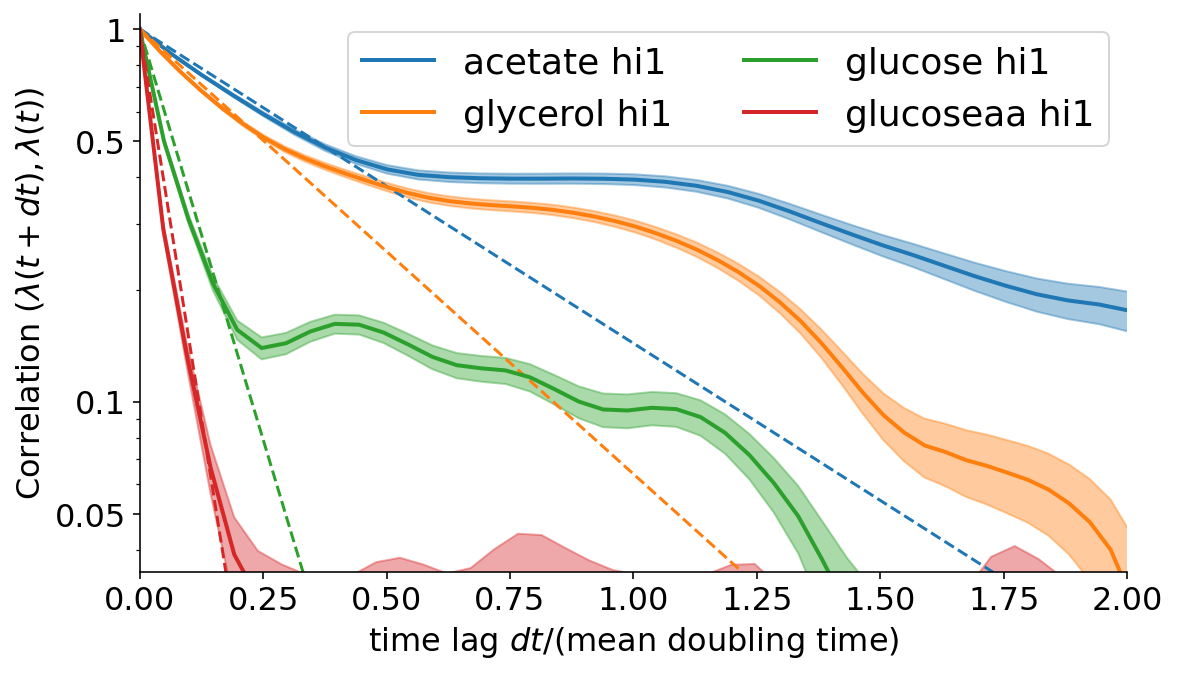

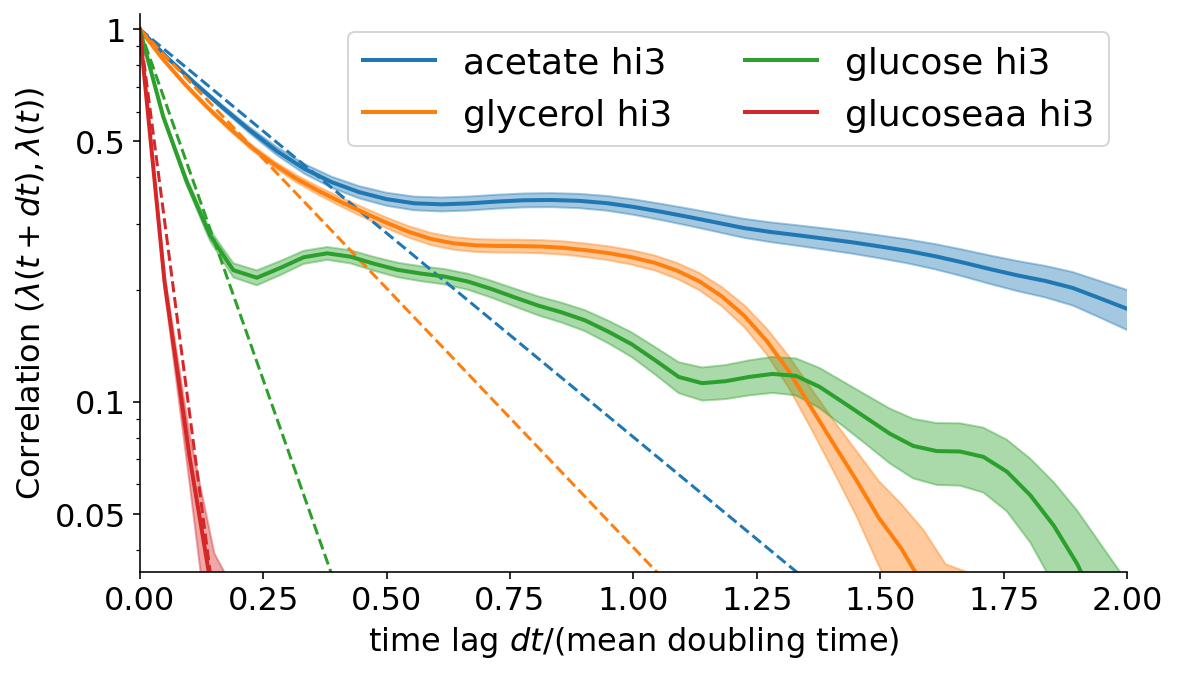

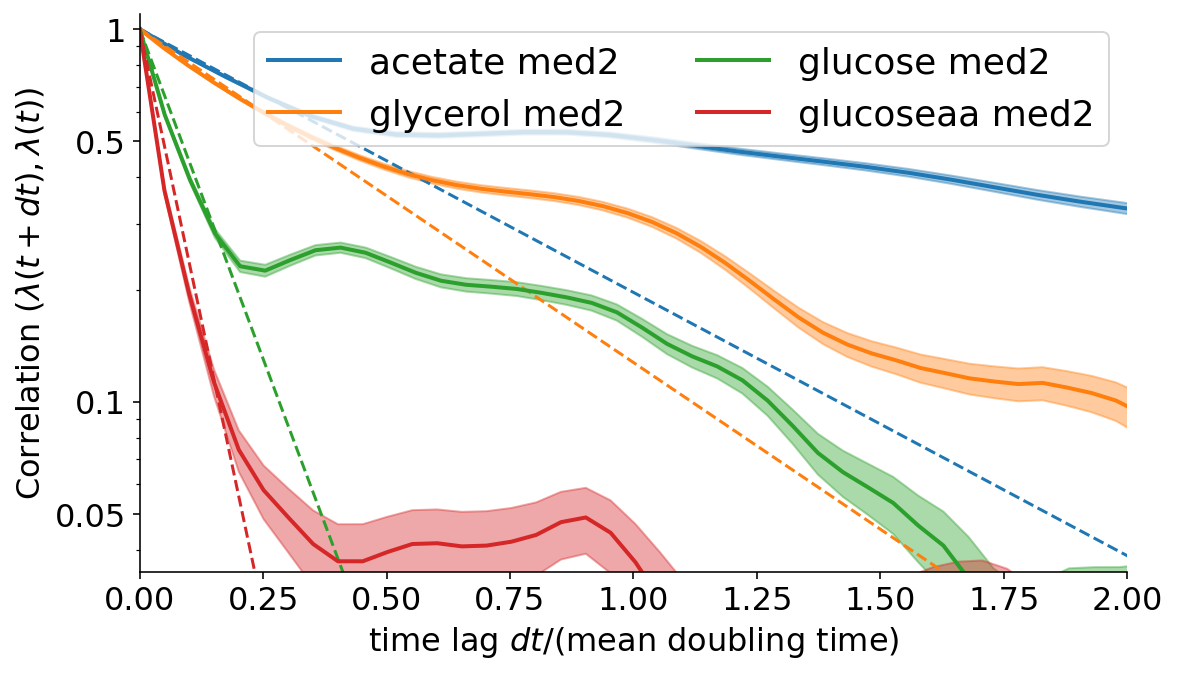

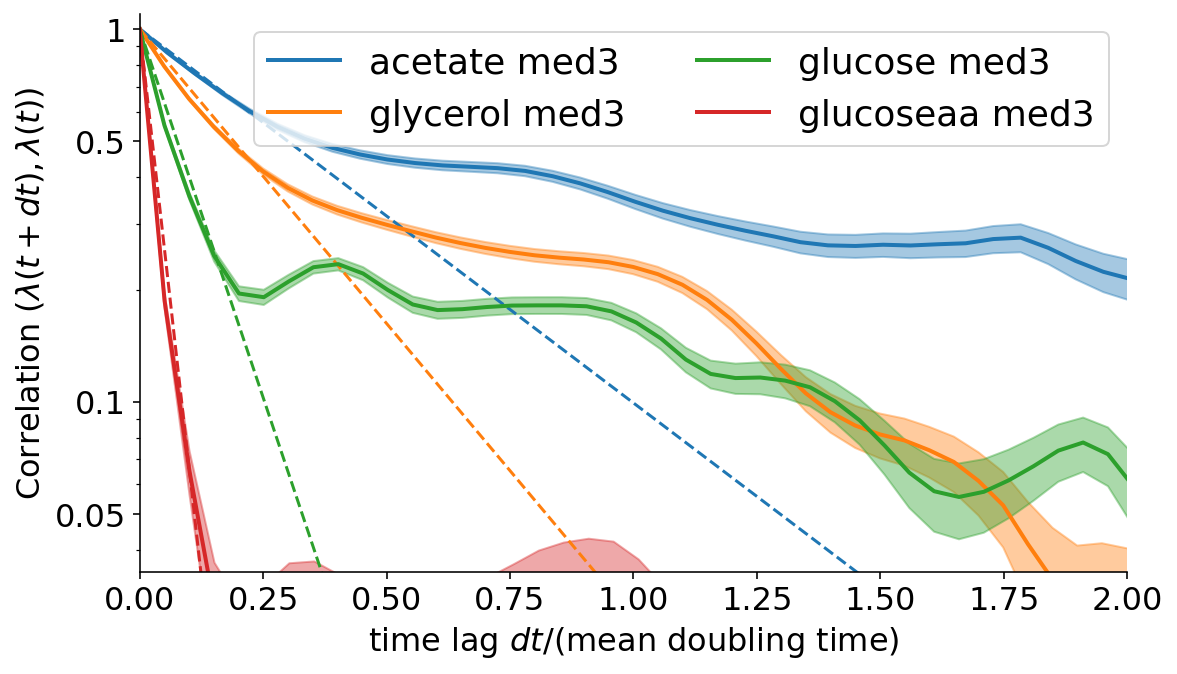

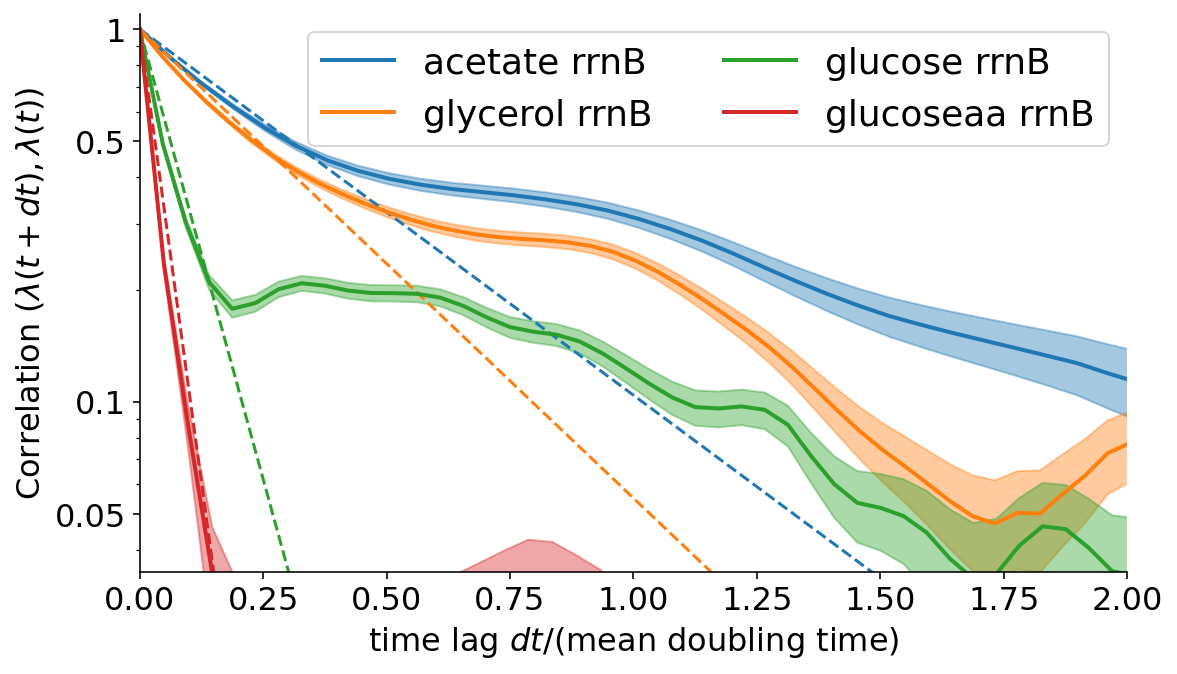

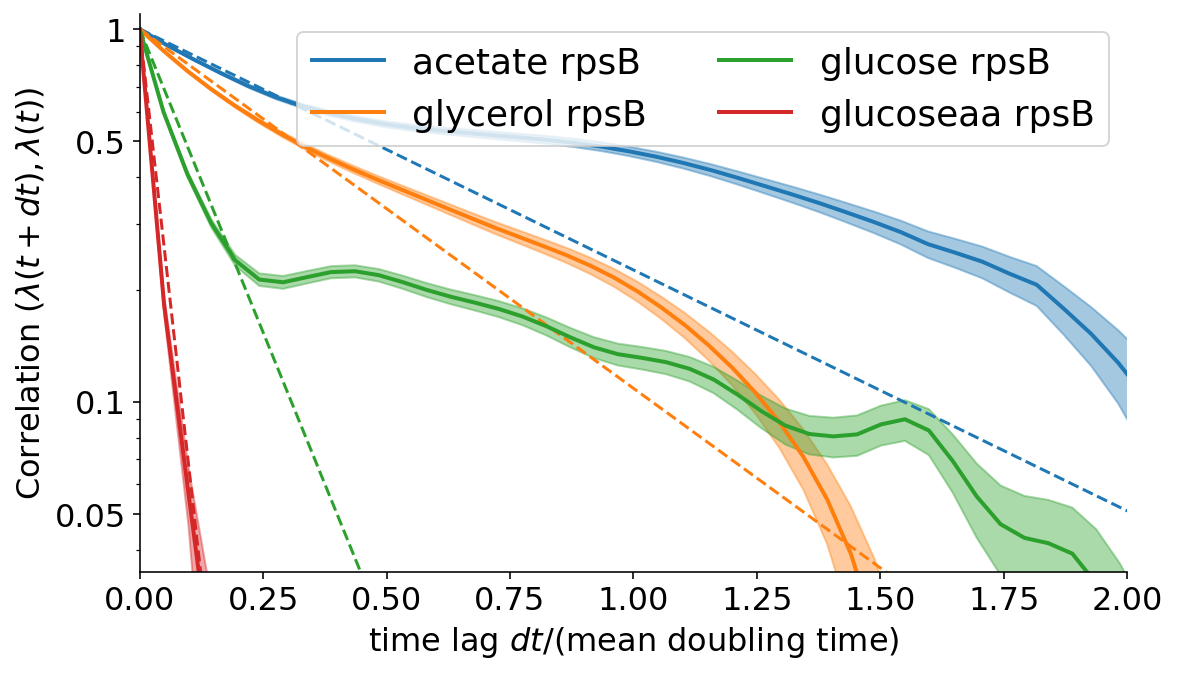

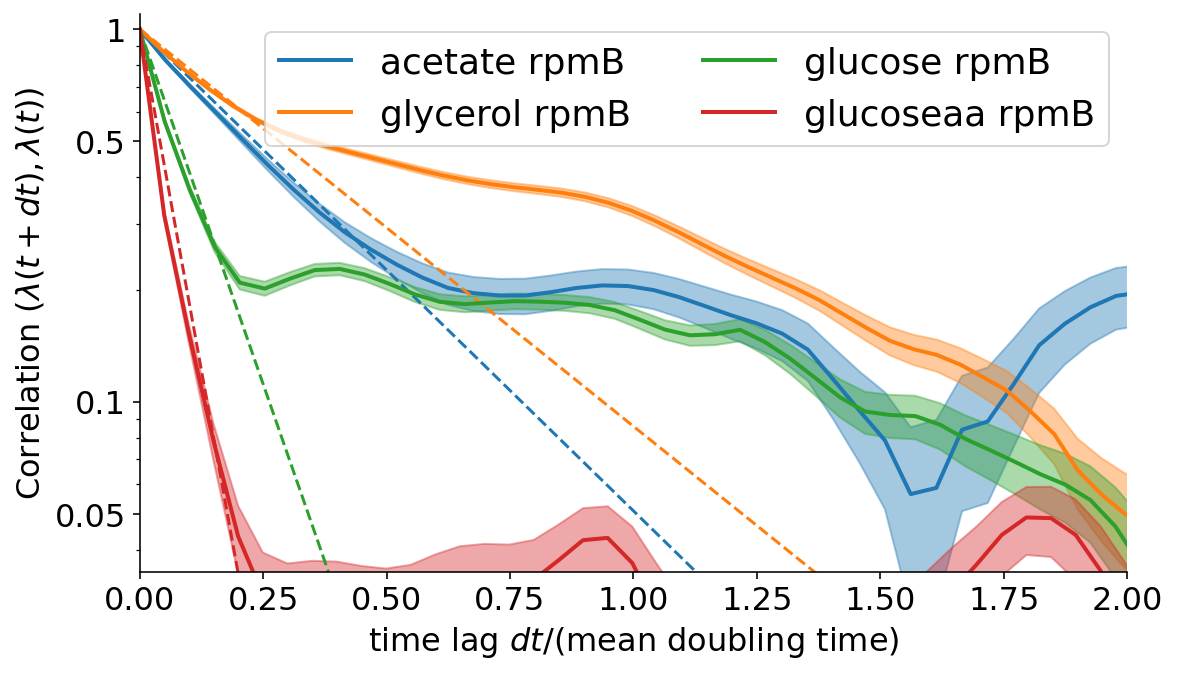

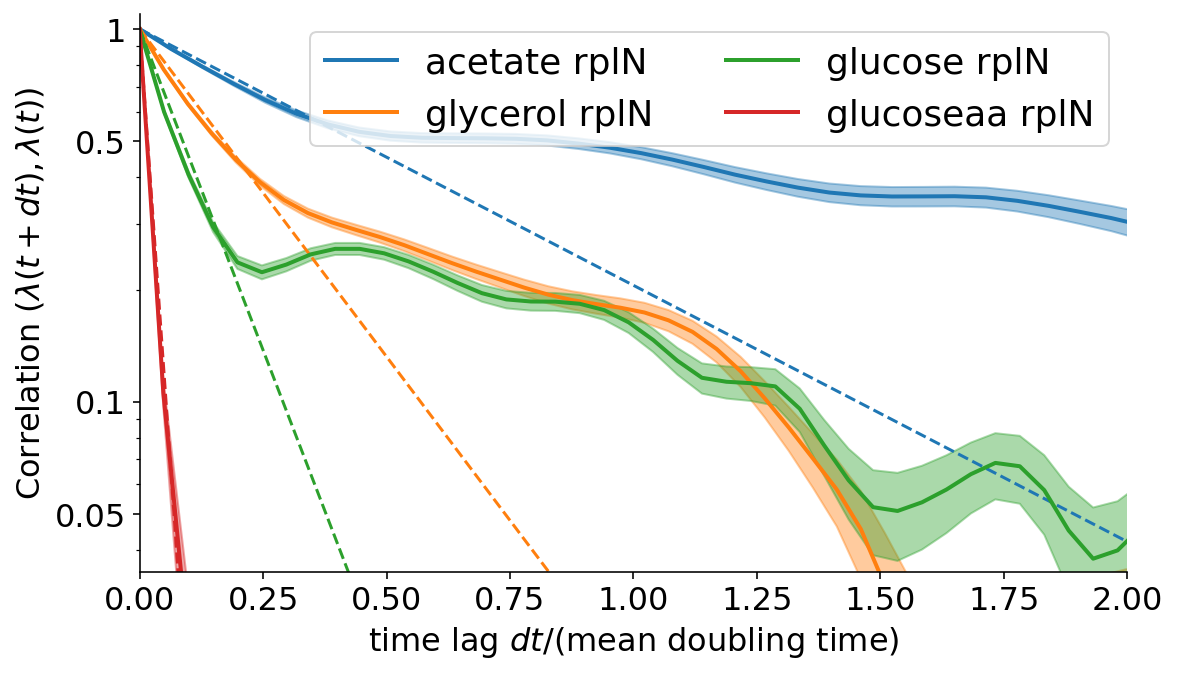

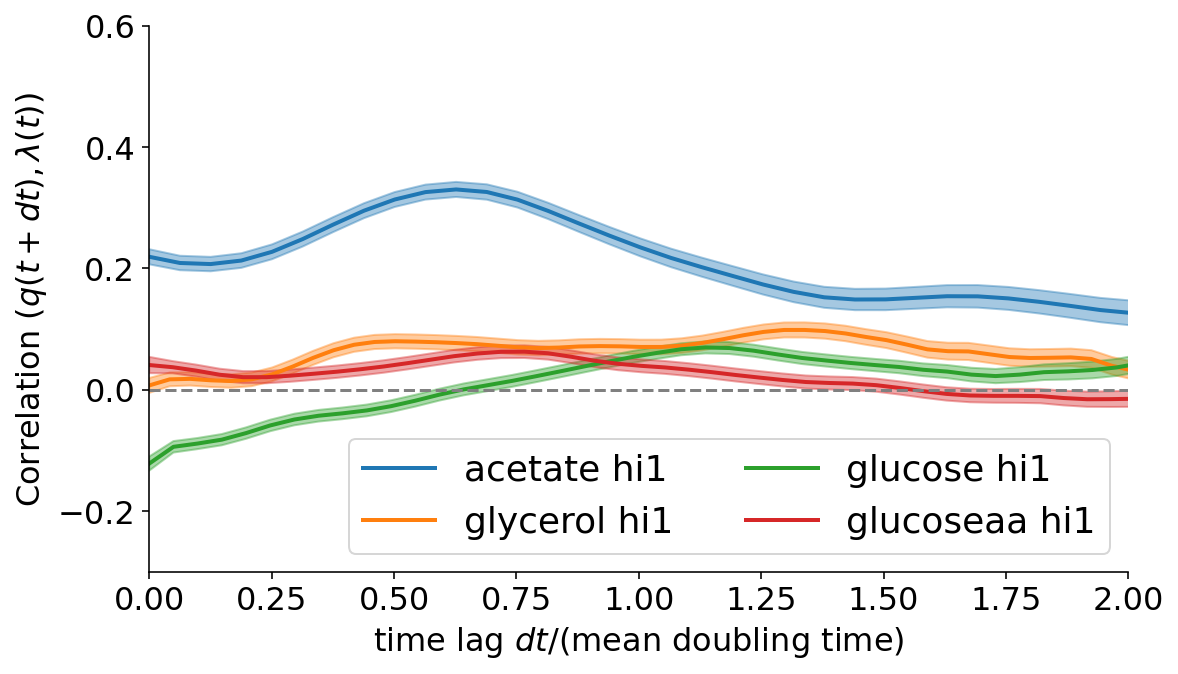

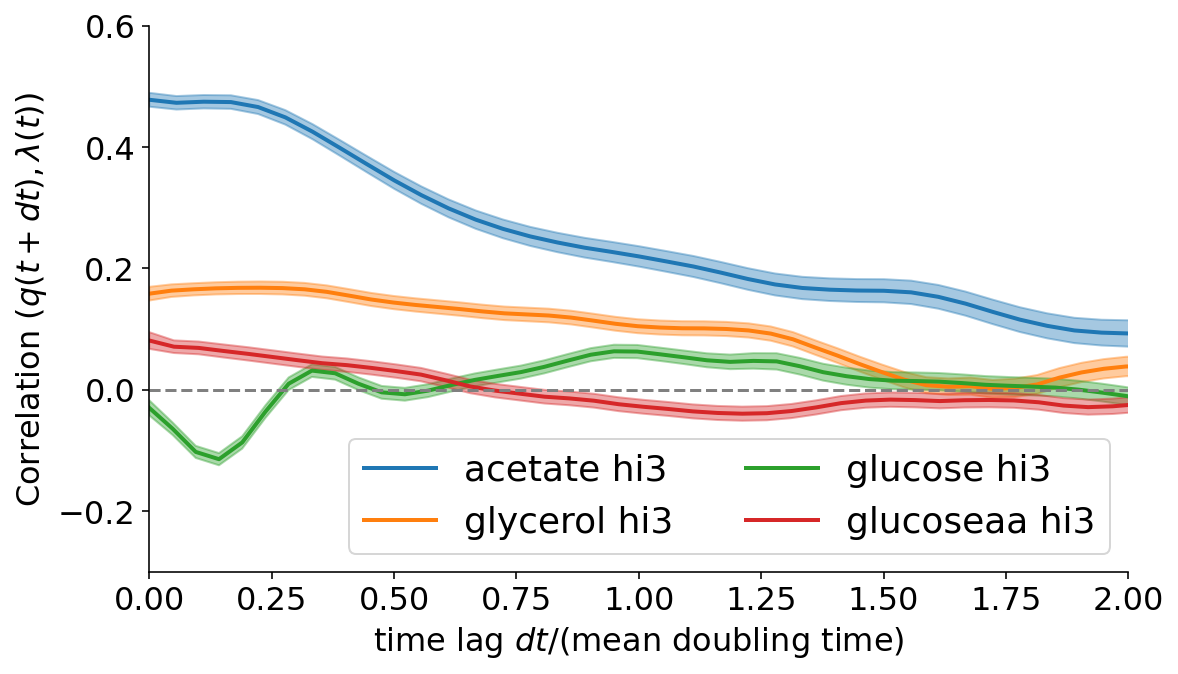

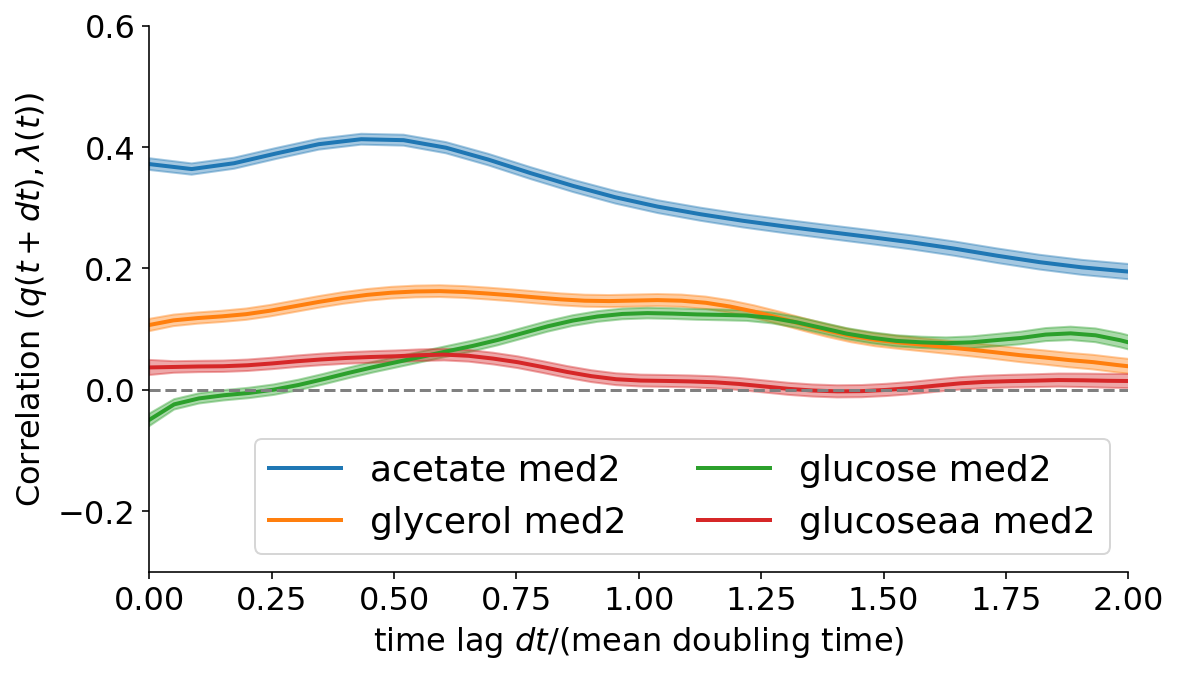

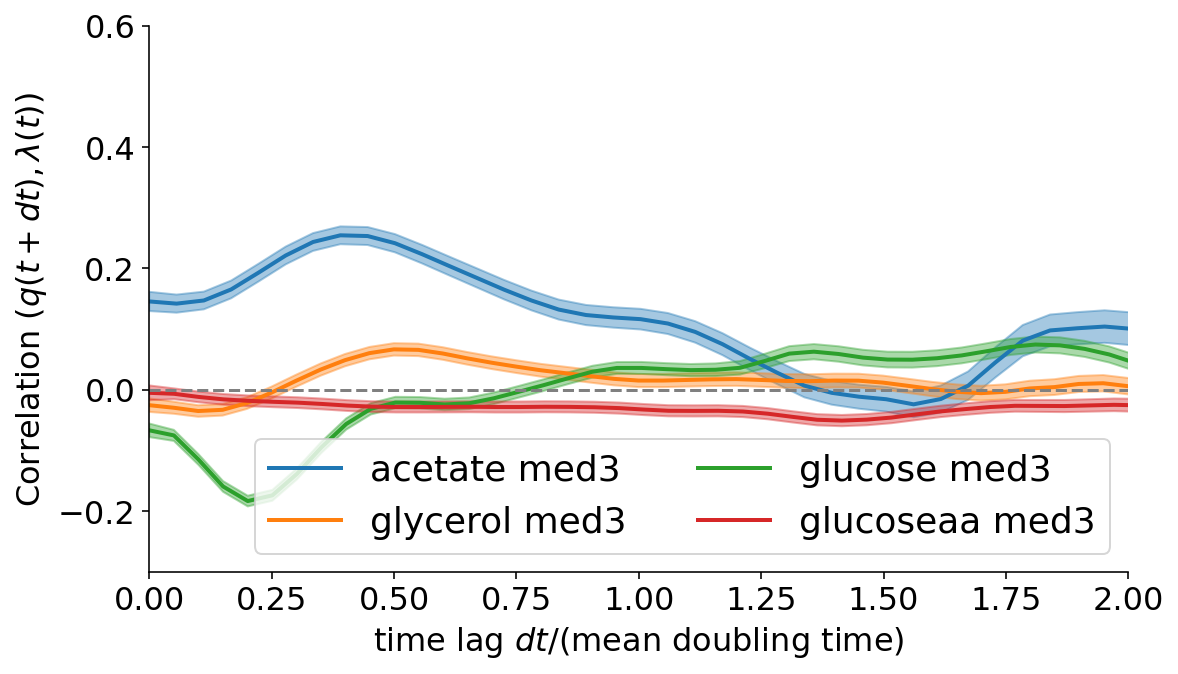

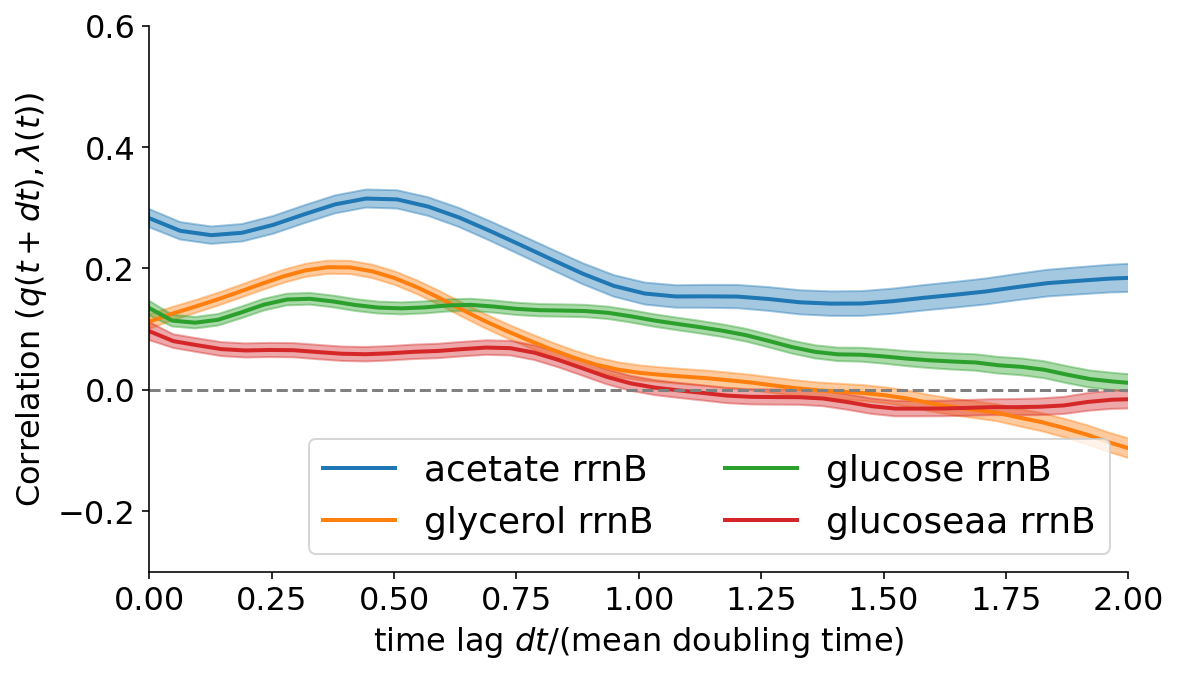

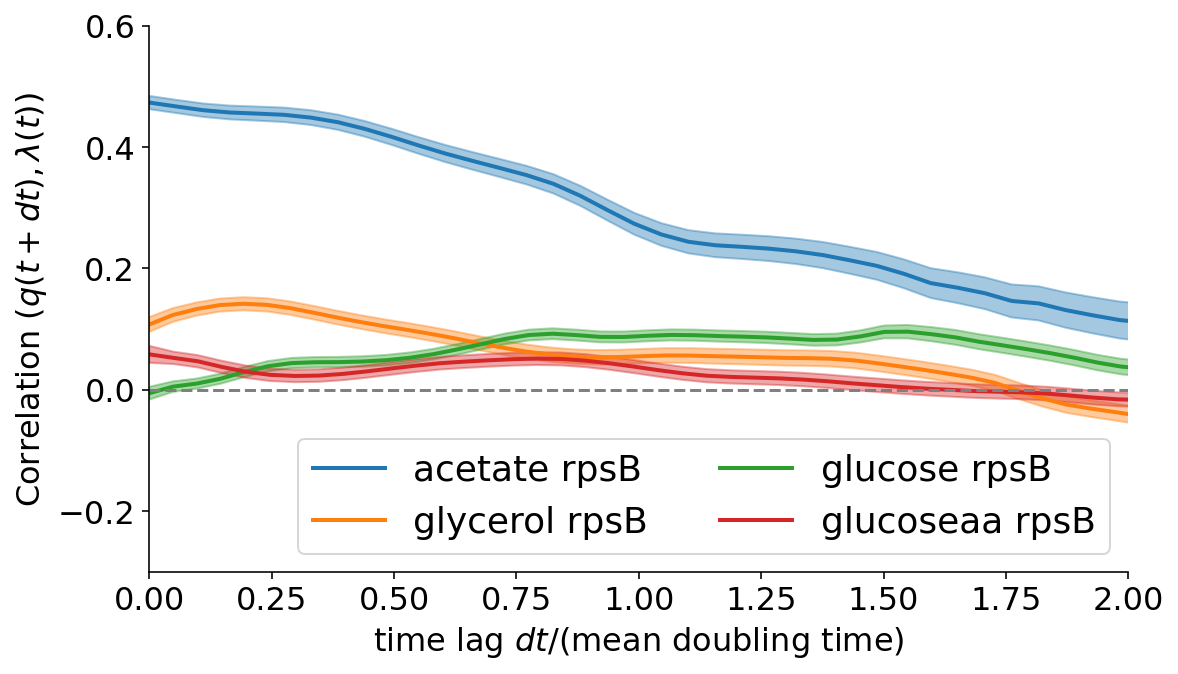

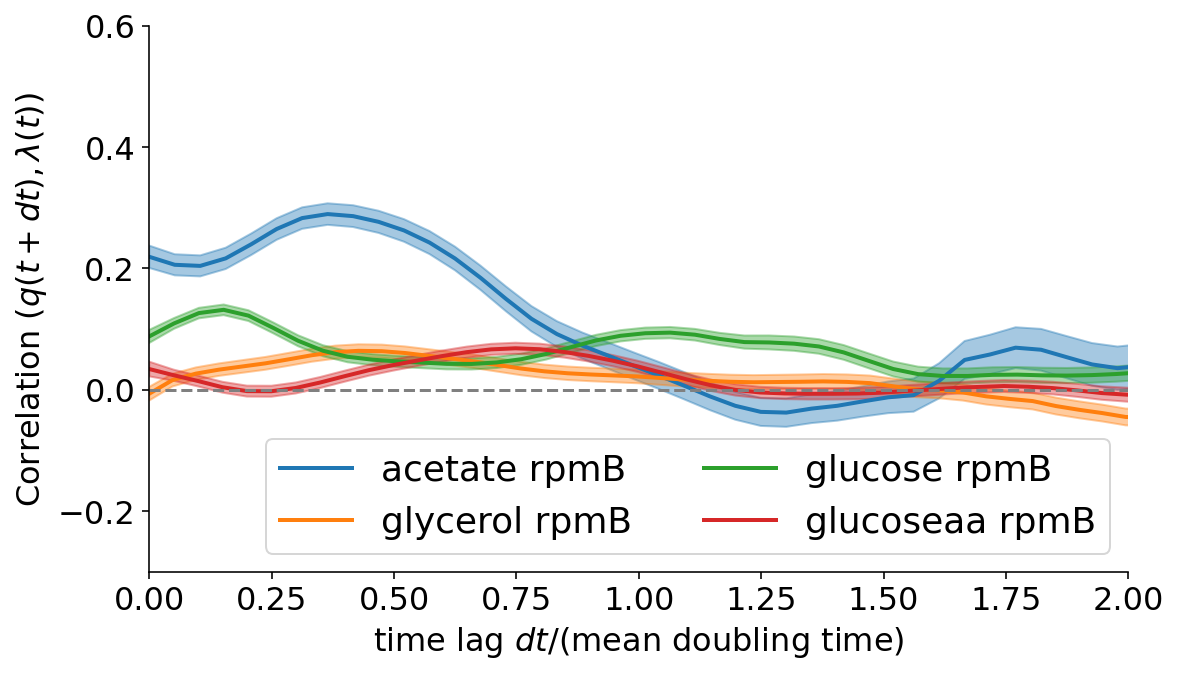

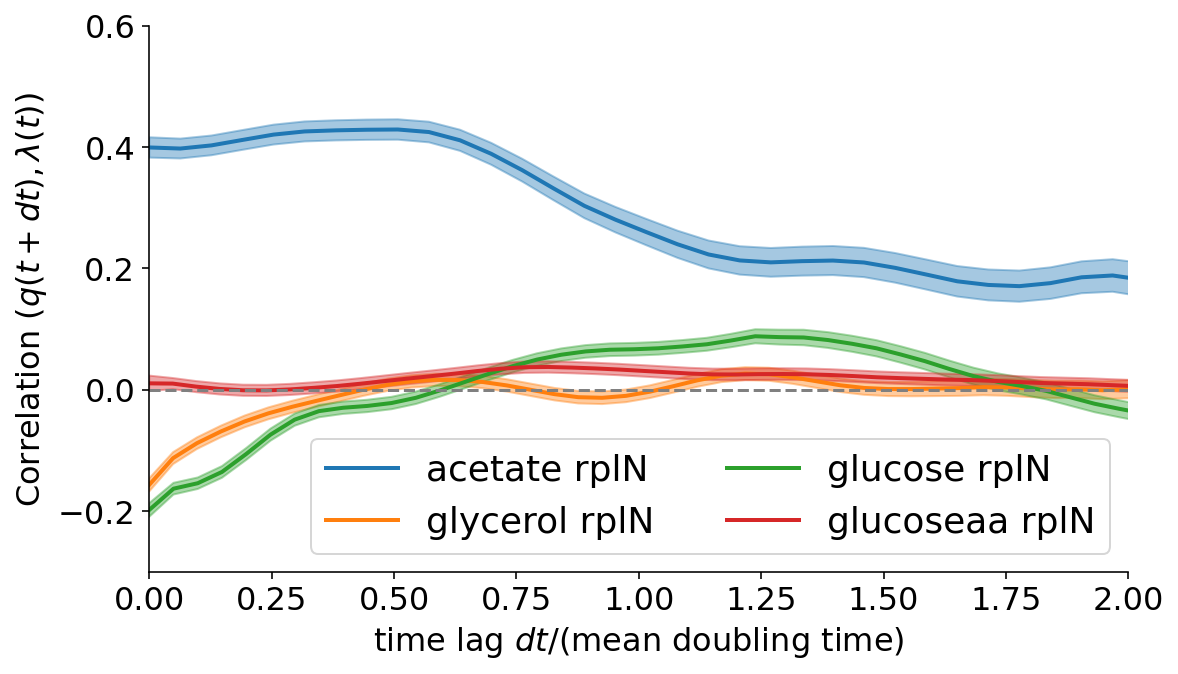

In [19]:
corr_dict = sort_dict(corr_dict, ["acetate", "glycerol", "glucose"])
gamma_lambdas = sort_dict(gamma_lambdas, ["acetate", "glycerol", "glucose"])
mean_lambdas = sort_dict(mean_lambdas, ["acetate", "glycerol", "glucose"])


for promoter in promoters[:]:
    plot_xy_correlation_list(get_filtered_values(corr_dict, promoter), 
                                "l(t+dt)", "l(t)", 
                                plot_file=plot_dir.format("l", "l", promoter), 
                                label=get_filtered_keys(corr_dict, promoter, keep="both"), 
                                gamma=get_filtered_values(gamma_lambdas, promoter), 
                                mean_lambda = get_filtered_values(mean_lambdas, promoter),
                                ylabel=r"Correlation $(\lambda(t+dt),\lambda(t))$",
                                scale_t=True, 
                                ylim=[0.035, 1.1], 
                                xlim=[0, 2], 
                                err_style="fill", 
                                log=True, 
                                min_joint_number=1)

for promoter in promoters[:]:
    plot_xy_correlation_list(get_filtered_values(corr_dict, promoter), 
                                "q(t+dt)", "l(t)", 
                                plot_file=plot_dir.format("q", "l", promoter), 
                                label=get_filtered_keys(corr_dict, promoter, keep="both"), 
                                # gamma=get_filtered_values(gamma_lambdas, promoter), 
                                mean_lambda = get_filtered_values(mean_lambdas, promoter),
                                ylabel=r"Correlation $(q(t+dt),\lambda(t))$",
                                scale_t=True, 
                                ylim=[-0.3, 0.6], 
                                xlim=[0, 2], 
                                err_style="fill", 
                                log=False, 
                                min_joint_number=1, 
                                highlight_zero=True)

In [13]:
# for condition, xmax, ymin in zip(conditions, [2.5, 2.5, 2, 1.5], [0.1, 0.05, 0.02, 0.01]):
#     plot_xy_correlation_list(get_filtered_values(corr_dict, condition), 
#                                 "l(t+dt)", "l(t)", 
#                                 plot_file=plot_dir.format("l", "l", condition), 
#                                 label=get_filtered_keys(corr_dict, condition, "promoter"), 
#                                 gamma=get_filtered_values(gamma_lambdas, condition), 
#                                 mean_lambda = get_filtered_values(mean_lambdas, condition),
#                                 scale_t=True, 
#                                 ylim=[ymin, 1.1], 
#                                 xlim=[0, xmax], 
#                                 ylabel=r"Correlation$(\lambda(t+dt),\lambda(t))$",
#                                 err_style=None, 
#                                 log=True, 
#                                 min_joint_number=1, 
#                                 fit=True)
    

## Tiles

Saved in ../../experimental_data/data_dany/data_dany_output_20220614/plots/plots_correlations_glucose_hi1_tiles_.pdf


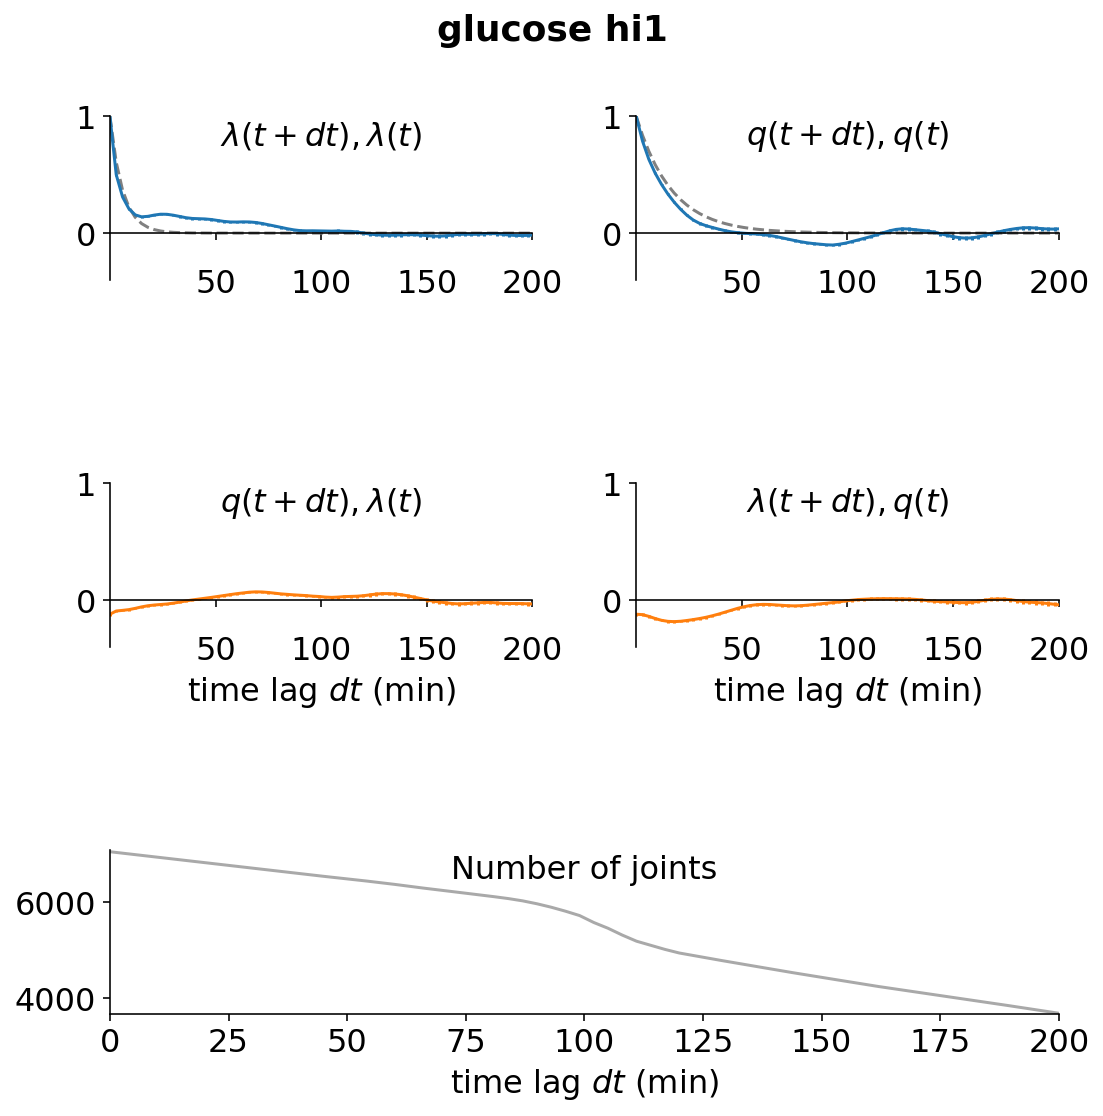

In [15]:
for k in corr_dict.keys():  
    if "glucose_" in k and "hi1" in k:
        plot_correlation_tiles(corr_dict[k], 
                                gamma_lambda=gamma_lambdas[k], 
                                gamma_q=gamma_qs[k], 
                                min_joint_number=1500, 
                                xlim=[0,200],
                                title=k, 
                                plot_file=plot_dir.format("glucose_hi1", "tiles", ""))

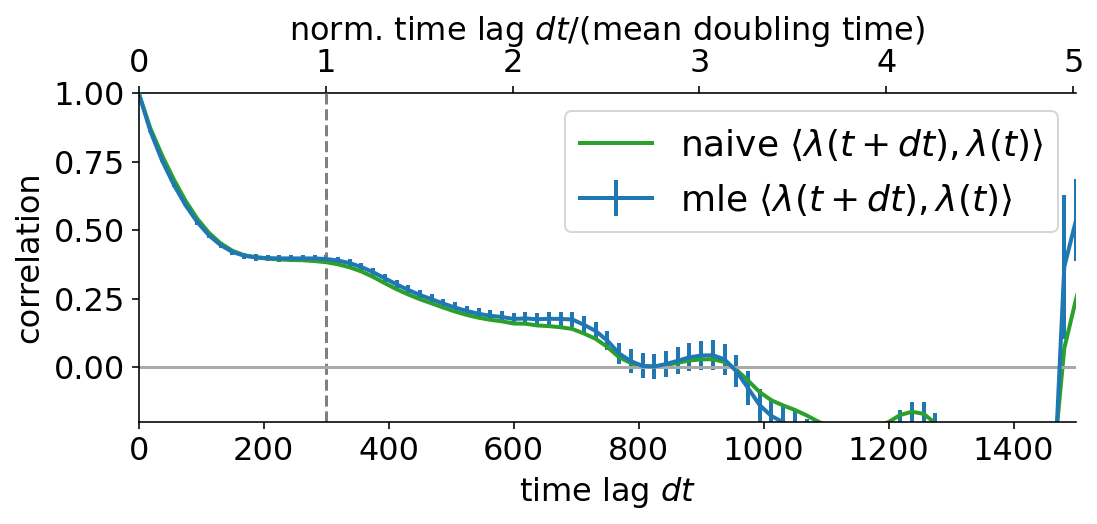

In [16]:
plot_xy_correlation(corr_dict["acetate_hi1"], "l(t+dt)", "l(t)", ylim=[-0.2, 1], xlim=[0, 1500], 
                mean_lambda=mean_lambdas["acetate_hi1"])


In [17]:
dts = np.arange(0, 4, 0.2)

filter = np.where(dts>0.5, True, False) *  np.where(dts<1.5, True, False)

dts[filter]

array([0.6, 0.8, 1. , 1.2, 1.4])